In [14]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

In [15]:
dataset = pd.read_csv("../Datasets/ENB2012_data.csv")
dataset = shuffle(dataset)
x_test = dataset.iloc[:50,:]
x_train = dataset.iloc[50:,:]
y_train = x_train.iloc[:,-2:]
y_test = x_test.iloc[:,-2:]
x_train = x_train.iloc[:,:-2]
x_test = x_test.iloc[:,:-2]
x_train_dummy = pd.get_dummies(x_train.iloc[:,-1])
x_test_dummy = pd.get_dummies(x_test.iloc[:,-1])
x_train['0'] = x_train_dummy.iloc[:,0]
x_train['1'] = x_train_dummy.iloc[:,1]
x_train['2'] = x_train_dummy.iloc[:,2]
x_train['3'] = x_train_dummy.iloc[:,3]
x_train['4'] = x_train_dummy.iloc[:,4]
x_train['5'] = x_train_dummy.iloc[:,5]
x_train.pop('X8')
x_test['0'] = x_test_dummy.iloc[:,0]
x_test['1'] = x_test_dummy.iloc[:,1]
x_test['2'] = x_test_dummy.iloc[:,2]
x_test['3'] = x_test_dummy.iloc[:,3]
x_test['4'] = x_test_dummy.iloc[:,4]
x_test['5'] = x_test_dummy.iloc[:,5]
x_test.pop('X8')

355    2
197    4
241    5
331    1
584    2
59     1
57     1
570    1
642    3
373    2
503    5
314    1
211    4
757    5
72     1
681    4
19     0
328    1
593    2
581    2
405    3
22     0
151    3
353    2
221    4
65     1
595    2
756    5
391    3
339    2
745    5
740    5
657    3
41     0
336    2
159    3
236    4
753    5
152    3
460    4
53     1
577    2
495    5
279    5
298    1
137    2
284    5
591    2
323    1
627    3
Name: X8, dtype: int64

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(50 ,activation='relu'))
model.add(layers.Dense(1,activation=keras.activations.softsign))

In [18]:
from tensorflow.keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [38]:
lrs = []
K1 = 0.
batch_size=32
epochs = 1000
num_classes = 2
from tqdm import tqdm

In [29]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    # print("The value of K_z is ",Kz)
    K1 = (1/batch_size)*(Kz)*max(q,1-q)*(1/num_classes)
    lr = 1 / K1
    lrs.append(lr)
    # print('Epoch', epoch, 'LR =', lr)
    return lr


In [21]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [22]:
import tensorflow.keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [23]:
q = 0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [24]:
history=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  11.603724
Epoch 0 LR = 5.805758892968812
The value of K_z is  55.54578
Epoch 1 LR = 1.2128449871805482
The value of K_z is  57.251987
Epoch 2 LR = 1.1767001294567394
The value of K_z is  58.80099
Epoch 3 LR = 1.1457021359687682
The value of K_z is  60.2365
Epoch 4 LR = 1.1183986667808938
The value of K_z is  61.576424
Epoch 5 LR = 1.0940619325507144
The value of K_z is  62.83332
Epoch 6 LR = 1.072176679353789
The value of K_z is  64.05193
Epoch 7 LR = 1.0517781055743554
The value of K_z is  65.18847
Epoch 8 LR = 1.0334407626870807
The value of K_z is  66.28132
Epoch 9 LR = 1.0164013391704323
The value of K_z is  67.357086
Epoch 10 LR = 1.0001682803047685
The value of K_z is  68.4345
Epoch 11 LR = 0.984421884142564
The value of K_z is  69.42762
Epoch 12 LR = 0.9703403503763264
The value of K_z is  70.42326
Epoch 13 LR = 0.9566216851763386
The value of K_z is  71.413284
Epoch 14 LR = 0.9433597923877214
The value of K_z is  72.35743
Epoch 15 LR = 0.9310505018498487
Th

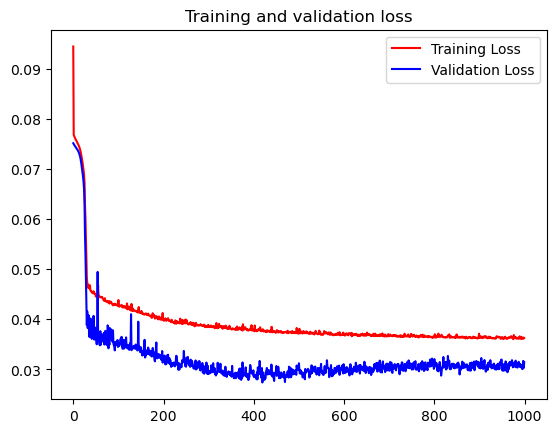

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [30]:
q = 0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test))

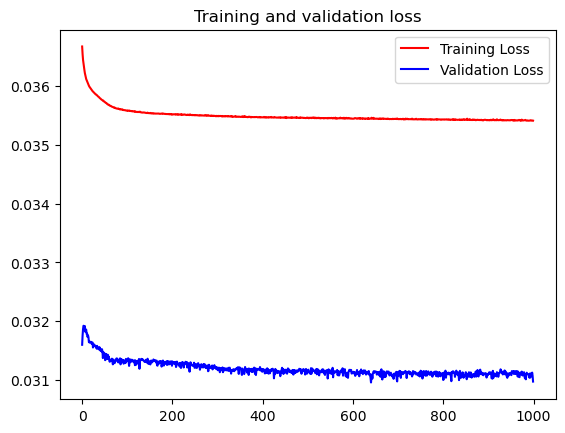

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history_const.history['loss']
val_loss = history_const.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


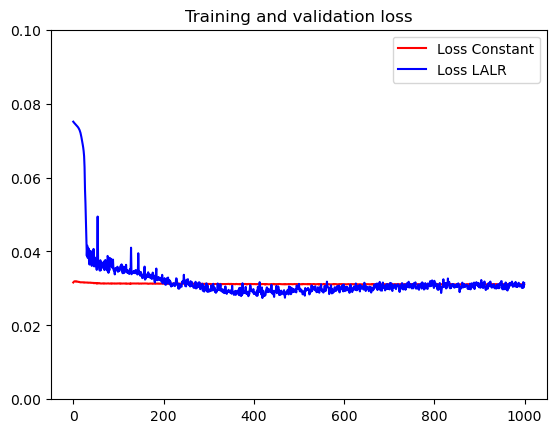

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
loss_const = history_const.history['val_loss']
loss_lalr = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training loss')
plt.ylim(0,0.1)
plt.legend()
plt.savefig('Training_Loss-Energy_Efficiency-Q5.png')
plt.show()


In [35]:
q = 0.95
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test), callbacks=[lr_scheduler])

The value of K_z is  225.11487
Epoch 0 LR = 0.2992624236775593
The value of K_z is  225.75702
Epoch 1 LR = 0.2984111915466479
The value of K_z is  225.9452
Epoch 2 LR = 0.29816264898099337
The value of K_z is  226.11166
Epoch 3 LR = 0.2979431485973681
The value of K_z is  226.2269
Epoch 4 LR = 0.29779138374186975
The value of K_z is  226.3093
Epoch 5 LR = 0.29768296020655516
The value of K_z is  226.3746
Epoch 6 LR = 0.2975970805869889
The value of K_z is  226.41666
Epoch 7 LR = 0.29754180675472963
The value of K_z is  226.4503
Epoch 8 LR = 0.29749759846085305
The value of K_z is  226.48668
Epoch 9 LR = 0.29744981615313365
The value of K_z is  226.51474
Epoch 10 LR = 0.2974129677191692
The value of K_z is  226.54242
Epoch 11 LR = 0.29737662915875784
The value of K_z is  226.55469
Epoch 12 LR = 0.2973605260435478
The value of K_z is  226.56757
Epoch 13 LR = 0.2973436236545131
The value of K_z is  226.58932
Epoch 14 LR = 0.2973150701920707
The value of K_z is  226.59761
Epoch 15 LR = 0.2

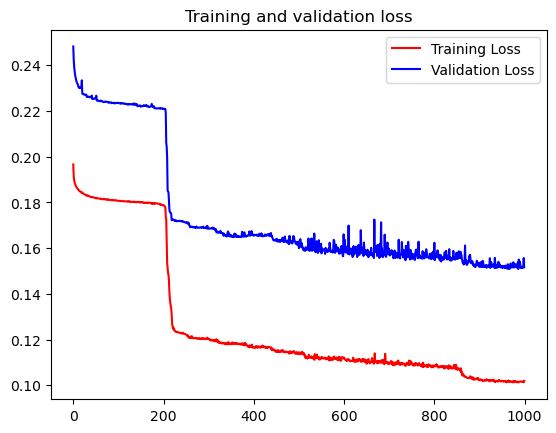

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [39]:
q = 0.95
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))

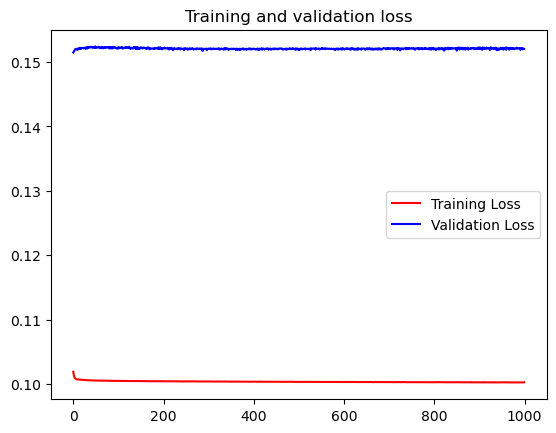

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history_const.history['loss']
val_loss = history_const.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


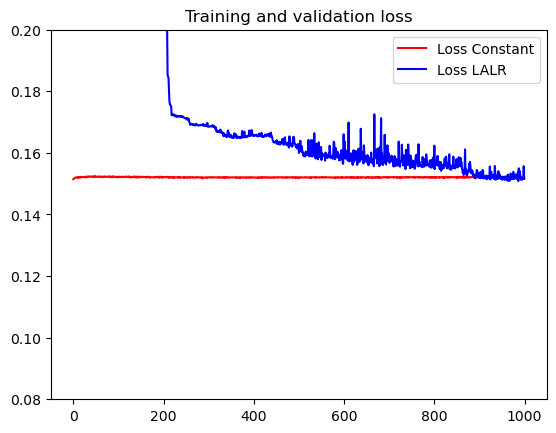

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
loss_const = history_const.history['val_loss']
loss_lalr = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training and validation loss')
plt.ylim(0.08,0.2)
plt.legend()
plt.savefig('Training_Loss-Energy_Efficiency-Q95.png')
plt.show()